In [137]:
import pandas as pd
import numpy as np
import math


def ewm(df):
    df = df.apply(lambda x: ((x - np.min(x)) / (np.max(x) - np.min(x))))
    rows, cols = df.shape
    k = 1.0 / math.log(rows)

    p = df / df.sum(axis=0)
    lnf = -np.log(p, where=df != 0) * p * k

    d = 1 - lnf.sum(axis=0)
    w = d / d.sum()

    w = pd.DataFrame(w)
    w = w.round(5)
    w.index = df.columns
    w.columns = ['weight']
    return w


weight = [0.01499,
          0.01371,
          0.42419,
          0.01306,
          0.00821,
          0.01341,
          0.00913,
          0.4914,
          0.01189]



In [138]:
# 计算原始政策评分

data = pd.read_excel(
    r"E:\Programing\PycharmProjects\2022MCM-B\Q3\数据\Q3数据.xlsx")  #The path and the name of the file

data = data.set_index('年')
myWeight = ewm(data)
newWeight = (np.array(weight) + np.array(myWeight['weight'].tolist())) / 2

data = data.values
data = (data - data.min(axis=0)) / (data.ptp(axis=0))
scatter = np.sum(data * newWeight, axis=1)
scatter

array([0.49017328, 0.50112091, 0.48079766, 0.45804368, 0.46571229,
       0.43584049, 0.41113744, 0.39615033, 0.39164528, 0.40225259,
       0.37001265, 0.34647663, 0.29244431, 0.32127201, 0.29938097,
       0.30940821, 0.34080498, 0.31157274, 0.36854881, 0.34630598,
       0.35917627, 0.43137373, 0.42953496, 0.41601134, 0.39553708,
       0.34073187, 0.3532953 , 0.42946136, 0.40321163, 0.45101645])

In [139]:
# 计算优化政策得分

data = pd.read_excel(
    r"E:\Programing\PycharmProjects\2022MCM-B\Q3\数据\Q3数据.xlsx",
    sheet_name='优化政策')  #The path and the name of the file

data = data.set_index('年')
idx = data.index
myWeight = ewm(data)
newWeight = (np.array(weight) + np.array(myWeight['weight'].tolist())) / 2

data = data.values
data = (data - data.min(axis=0)) / (data.ptp(axis=0))
scatterTuning = np.sum(data * newWeight, axis=1)
scatterTuning


array([0.48677231, 0.4965132 , 0.47710366, 0.4566589 , 0.46514574,
       0.43649124, 0.41376679, 0.39941302, 0.39566452, 0.40705988,
       0.37665177, 0.35513828, 0.30460753, 0.33064902, 0.31075595,
       0.31986631, 0.35330417, 0.2999559 , 0.38376457, 0.36373163,
       0.37896428, 0.4507721 , 0.44979233, 0.4378529 , 0.41996859,
       0.36714344, 0.381558  , 0.45933512, 0.43553514, 0.45510846])

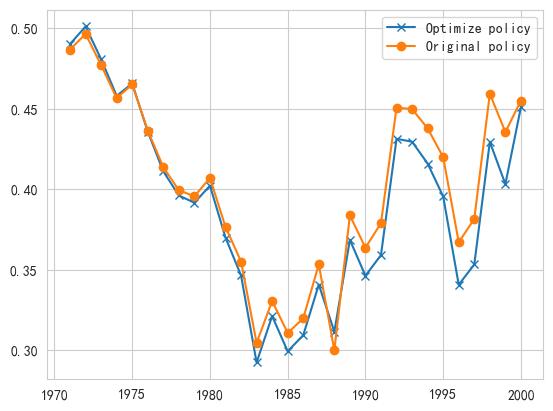

In [140]:
scatter_ = scatter = pd.DataFrame(scatter, index=idx)
scatterTuning_ = scatterTuning = pd.DataFrame(scatterTuning, index=idx)
x = scatter.index.tolist()

# 对比二者指标

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(x, scatter, marker='x', label='Optimize policy')
ax.plot(x, scatterTuning, marker='o', label='Original policy')

plt.legend()
plt.savefig('Optimize policy vs Original policy.svg')
plt.show()

可以得出优化政策总体是要好于原政策的

完成数据 级比校验, 平移变换c=1.0000000000000004
发展系数a=0.0005180643782786479, 灰色作用量b=1.4106966413649742

后验差比=0.9093354402094963, 后验差比>0.65，模型精度等级为不合格 

返回值为dataframe，可通过.res_df拿到, 可通过.plot_res画预测图
          原始值       预测值        残差    相对误差      级比偏差
0   0.486772  0.486772  0.000000   0.00%       NaN
1   0.496513  0.409561  0.086952  17.51%  0.020126
2   0.477104  0.408831  0.068272  14.31% -0.040143
3   0.456659  0.408102  0.048557  10.63% -0.044229
4   0.465146  0.407372  0.057774  12.42%  0.018754
5   0.436491  0.406643  0.029848   6.84% -0.065095
6   0.413767  0.405915  0.007852   1.90% -0.054375
7   0.399413  0.405187 -0.005774   1.45% -0.035401
8   0.395665  0.404459 -0.008794   2.22% -0.008951
9   0.407060  0.403731  0.003328   0.82%  0.028498
10  0.376652  0.403004 -0.026353   7.00% -0.080173
11  0.355138  0.402278 -0.047139  13.27% -0.060028
12  0.304608  0.401551 -0.096944  31.83% -0.165284
13  0.330649  0.400826 -0.070176  21.22%  0.079236
14  0.310756  0.400100 -0.089344  28.75% -0.06346

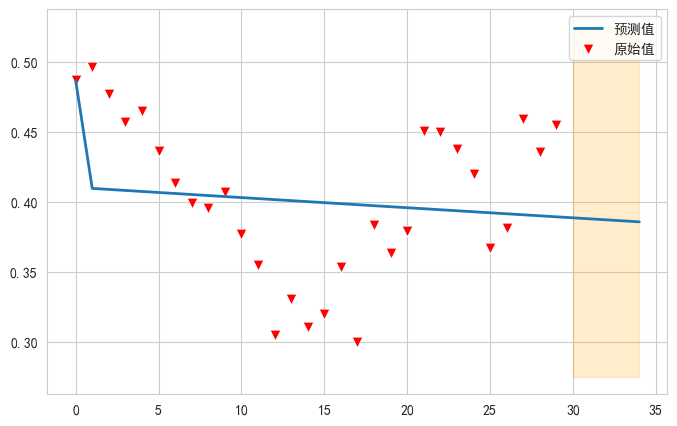

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


class GrayForecast():
    # 初始化
    def __init__(self, data, n):
        """
        :param data: Series/np/list
        :param n: 预测数量
        """
        plt.rcParams['font.sans-serif'] = ['SimHei']
        plt.rcParams['axes.unicode_minus'] = False
        if isinstance(data, pd.Series):
            self.data = data.values
        elif isinstance(data, np.ndarray):
            self.data = data
        elif isinstance(data, list):
            self.data = np.array(data)
        self.level_check()
        self.GM_11_build_model(n)
        print("返回值为dataframe，可通过.res_df拿到, 可通过.plot_res画预测图\n", self.res_df)

    def level_check(self):
        # 数据级比校验
        b = self.data[0]
        n = len(self.data)
        lambda_k = np.zeros(n - 1)
        while (True):
            for i in range(n - 1):
                lambda_k[i] = self.data[i] / self.data[i + 1]
            if max(lambda_k) < np.exp(2 / (n + 2)) and min(lambda_k) > np.exp(-2 / (n + 1)):
                self.c = self.data[0] - b
                print(f"完成数据 级比校验, 平移变换c={self.c}")
                break
            else:
                self.data = self.data + 0.1

    # GM(1,1)建模
    def GM_11_build_model(self, n):
        '''
            灰色预测
            x：序列，numpy对象
            n:需要往后预测的个数
        '''
        x = self.data
        # 累加生成（1-AGO）序列
        x1 = x.cumsum()
        # 紧邻均值生成序列
        z1 = (x1[:len(x1) - 1] + x1[1:]) / 2.0
        z1 = z1.reshape((len(z1), 1))
        B = np.append(-z1, np.ones_like(z1), axis=1)
        Y = x[1:].reshape((len(x) - 1, 1))
        # a为发展系数 b为灰色作用量
        [[a], [b]] = np.dot(np.dot(np.linalg.inv(np.dot(B.T, B)), B.T), Y)  # 计算参数
        # 预测数据
        fit_res = [x[0]]
        for index in range(1, len(x) + n):
            fit_res.append((x[0] - b / a) * (1 - np.exp(a)) * np.exp(-a * (index)))
        # 数据还原
        self.data -= self.c
        fit_res -= self.c
        self.res_df = pd.concat([pd.DataFrame({'原始值': self.data}), pd.DataFrame({'预测值': fit_res})], axis=1)
        print(f"发展系数a={a}, 灰色作用量b={b}\n")
        self.verfify(self.data, fit_res, a)
        return self.res_df

    def verfify(self, x, predict, a):
        S1_2 = x.var()  # 原序列方差
        e = list()  # 残差序列
        for index in range(x.shape[0]):
            e.append(x[index] - predict[index])
        S2_2 = np.array(e).var()  # 残差方差
        C = S2_2 / S1_2  # 后验差比
        if C <= 0.35:
            assess = '后验差比<=0.35，模型精度等级为好'
        elif C <= 0.5:
            assess = '后验差比<=0.5，模型精度等级为合格'
        elif C <= 0.65:
            assess = '后验差比<=0.65，模型精度等级为勉强'
        else:
            assess = '后验差比>0.65，模型精度等级为不合格'
        print(f"后验差比={C}, {assess} \n")

        # 级比偏差
        a_ = (1 - 0.5 * a) / (1 + 0.5 * a)
        delta = [np.nan]
        for i in range(x.shape[0] - 1):
            delta.append(1 - a_ * (x[i] / x[i + 1]))

        self.res_df = pd.concat([self.res_df, pd.DataFrame({'残差': e}),
                                 pd.DataFrame({'相对误差': list(map(lambda x: '{:.2%}'.format(x), np.abs(e / x)))}),
                                 pd.DataFrame({'级比偏差': delta})
                                 ],
                                axis=1)

    def plot_res(self, xlabel='', ylabel=''):
        res_df = self.res_df
        f, ax = plt.subplots(figsize=(8, 5))
        sns.lineplot(x=res_df.index.tolist(), y=res_df['预测值'], linewidth=2, ax=ax, label='预测值')
        sns.scatterplot(x=res_df.index.tolist(), y=res_df['原始值'], s=60, color='r', marker='v', ax=ax, label='原始值')
        plt.fill_between(np.where(np.isnan(res_df["原始值"]))[0], y1=min(plt.yticks()[0]), y2=max(plt.yticks()[0]),
                         color='orange', alpha=0.2)
        ax.set_xlabel(xlabel, fontsize=15)
        ax.set_ylabel(ylabel, fontsize=15)
        plt.show()


data = scatterTuning[0].values
gm = GrayForecast(data, 5)  # 预测后面5个数据
res_df = gm.res_df
gm.plot_res()

In [142]:
def TDGM(x):
    x0 = x.copy()
    x1 = np.array([np.sum(x0[:i + 1]) for i in range(x0.shape[0])])
    z1 = np.array([(x1[i] + x1[i + 1]) / 2 for i in range(x1.shape[0] - 1)])
    Y = x0[1:][:, None]
    B = np.c_["1", -z1[:, None], np.arange(2, x0.shape[0] + 1)[:, None], np.ones((x0.shape[0] - 1, 1))]
    p = np.linalg.inv(B.T @ B) @ B.T @ Y
    a, b, c = p.T[0]
    alf = x0[0] * ((1 - 0.5 * a) / (1 + 0.5 * a) - 1) + 2 * b / (1 + 0.5 * a) + c / (1 + 0.5 * a)
    bata = (1 - 0.5 * a) / (1 + 0.5 * a)
    gam = b / (1 + 0.5 * a)
    return alf, bata, gam

In [143]:
from scipy.interpolate import make_interp_spline, interp1d


def smooth_xy(x_value: np.ndarray, y_value: np.ndarray, funSmooth):
    model = funSmooth(x_value, y_value)
    x_smooth = np.linspace(x_value.min(), x_value.max(), 500)
    y_smooth = model(x_smooth)
    return x_smooth, y_smooth

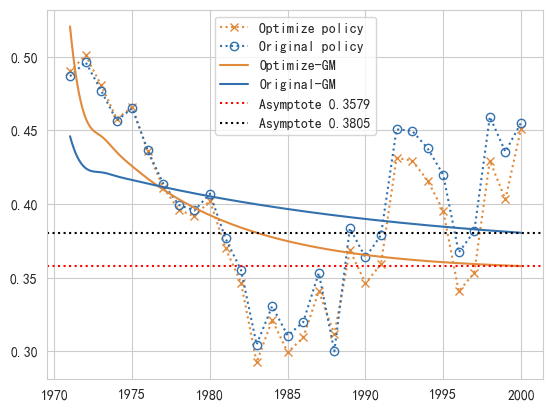

In [144]:
func = lambda k, *a: a[0] * a[1] ** (k - 2) + np.sum([a[2] * a[1] ** i for i in range(0, k - 2)])
prex1 = np.array([func(i, *TDGM(scatter[0].values)) for i in range(1, scatter[0].values.shape[0] + 1)])
prex2 = np.array([func(i, *TDGM(scatterTuning[0].values)) for i in range(1, scatterTuning[0].values.shape[0] + 1)])

fig, ax = plt.subplots()
ax.plot(x, scatter_, ls=':', marker='x', label='Optimize policy', color='#e18a3b')
ax.plot(x, scatterTuning_, ls=':', mfc="None", marker='o', label='Original policy', color='#3271ae')

# 平滑处理
_, prex1Smooth = smooth_xy(idx, prex1, make_interp_spline)
x_, prex2Smooth = smooth_xy(idx, prex2, make_interp_spline)
ax.plot(x_, prex1Smooth, color='#e18a3b', label='Optimize-GM')
ax.plot(x_, prex2Smooth, color='#3271ae', label='Original-GM')

ax.axhline(y=prex1Smooth[-1], ls=":", color="r", label=f'Asymptote {round(prex1Smooth[-1], 4)}')
ax.axhline(y=prex2Smooth[-1], ls=":", color="k", label=f'Asymptote {round(prex2Smooth[-1], 4)}')

plt.legend()
plt.savefig('forecast.svg')
plt.show()